<a href="https://colab.research.google.com/github/geraldoferreira1963/MVP_Analise_Dados/blob/main/MVP_1_Analise_Dados_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivo do trabalho **

Analisar dois datasets, (i) um relacionado a emissão de CO2 na Cadeia de Produção de Alimentos (com uma discriminação das emissões em diversos pontos da Cadeia, bem como nas etapas de produção de uma cultura), (ii) e um segundo dataset relacionado a produção de alimentos (discriminados por paises e por diversas culturas), além de explorar os datasets, verificar possíveis relacionamentos entre as culturas e a emissão de **CO2**

In [88]:
# carregando os módulos e bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
from collections import defaultdict
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from prettytable import PrettyTable
#from sklearn.metrics import mean_squared_error
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
import editdistance





# **Apresentação dos Datasets**


(1) Agri-food CO2 emission dataset - Forecasting ML ( https://www.kaggle.com/datasets/alessandrolobello/agri-food-co2-emission-dataset-forecasting-ml ) lista as emissões de CO2 relacionados relacionados com agronegócio. Os  campos abaixo estão presentes no dataset:

(1) Savanna fires : emissão de CO2 devido a incêndios neste biomassa

(2) Forest fires : emissão de CO2 devido a incêndios nas florestas

(3) Crop Residues : emissão decorrente da colheita da cultura (resíduos gerados)

(4) Rice Cultivation: emissão decorrente da criação de arroz

(5) Drained organic soils (CO2): Emissões de dióxido de carbono liberadas ao drenar solos orgânicos.

(6) Pesticides Manufacturing: emissão na fabricação de defensivos agricolas

(7) Food Transport: emissão devido ao transporte do alimento

(8) Forestland: Basicamente este campo é uma proxy para a captura de CO2, consequentemente é um valor negativo (no sentido de que ele absorve CO2)

(9)Net Forest conversion: Uma proxy que associa o desmatamento com a emissão de CO2

(10) Food Household Consumption: emissões decorrente do consumo de alimentos

(11) Food Retai : emissões das operações de varejo

(12) On-farm Electricity Use: consumo de energia das fazendas

(13) Food Packaging: Emissões da produção/ descarte das embalagens dos alimentos.

(14) Agrifood Systems Waste Disposal : emissões devido ao descarte

(15) Food Processing: Emissões do processamento de produtos alimentícios.

(16) Fertilizers Manufacturing : Emissões na produção de defensivos agricolas.

(17) IPPU: Emissões nos  processos industriais e no uso de produtos.

(18) Manure applied to Soils: Emissões decorrente da utilização de esterco animal

(19) Manure left on Pasture : Emissões do dejeto animal em pastagens ou terras de pastagem.

(20) Manure Management : emissões da gestão e tratamento de esterco animal.

(21) Fires in organic soilss: Emissões de incêndios nos solos organicos.

(22) Fires in humid tropical forests : Emissões decorrentes dos  incêndios nas florestas

(23) On-farm energy use : Emissão decorrent do consumo de energia nas fazendas.

(24) Rural population : Número de pessoas nas rurais.

(25) Urban population : Número de pessoas nas áreas urbanas.

(26) Total Population - Masculino: População total masculina

(27) Total Population - Female : População total feminina

(28) total_emission: emissão total de CO2 (somatória 1 até 23)

(29) Average Temperature °C : Aumento médio da Temperatura


(2) Crop statistics FAO - All countries (https://www.kaggle.com/datasets/raghavramasamy/crop-statistics-fao-all-countries) dataset que tem como base os dados da FAO com relação a produção de alimento ( http://www.fao.org/faostat/en/#data/QC), contendo dados de safras de 173 produtos de diversos paises, abrangendo diversas categorias: Culturas primárias, Cereais, Grãos, Frutas, Raízes e tubérculos, Vegetais, etc.

In [89]:
url_1 = 'https://raw.githubusercontent.com/geraldoferreira1963/MVP_Analise_Dados/main/Agrofood_co2_emission.csv'
url_2 ='https://raw.githubusercontent.com/geraldoferreira1963/MVP_Analise_Dados/main/Crop.csv'

response_1 = requests.get(url_1)
response_2 = requests.get(url_2)


file_content_1 = response_1.text
file_1 = StringIO(file_content_1)

file_content_2 = response_2.text
file_2 = StringIO(file_content_2)


df_alimentos_emissao_co2=pd.read_csv(file_1)
df_producao_alimentos=pd.read_csv(file_2, delimiter=';')



#                  # **Definição de Funções**

(1) Classificar a cultura : recebe uma string com um nome de uma plantação, e classifica a mesma de acordo com um dicionário de culturas previamente definido. A definição da categoria não segue rigorosamente as categorias da área.

(2) Recebe dois dataframes tendo uma coluna com o nome de um país, e a função verifica as diferenças entre as duas colunas (cada uma em um dataframe).

(3) função para formatar plotagem

(4) Função para formatar uma análise de covariance usando Heatmap

In [90]:
def classificacao_cultura (cultura) :
  Dicionario_cultura=defaultdict(lambda : "Não encontrado")
  Dicionario_culturas = {
    "Frutas":               ["Apples", "Apricots", "Berries nes", "Figs", "Fruit, citrus nes", "Fruit, fresh nes", "Fruit, stone nes", "Grapes", "Melons, other (inc.cantaloupes)",
                             "Oranges", "Peaches and nectarines", "Pears", "Plums and sloes", "Watermelons", "Citrus Fruit, Total", "Fruit Primary", "Fruit, tropical fresh nes",
                             "Grapefruit (inc. pomelos)", "Lemons and limes", "Mangoes, mangosteens, guavas", "Papayas", "Pineapples", "Strawberries",
                             "Tangerines, mandarins, clementines, satsumas", "Bananas", "Dates", "Kiwi fruit", "Persimmons", "Raspberries", "Blueberries", "Currants", "Gooseberries",
                             "Cranberries", "Cashewapple","Avocados", "Quinces", "Plantains and others", "Fruit, pome nes", "Carobs"],
    "Vegetais":             ["Onions, dry", "Potatoes", "Vegetables, fresh nes", "Vegetables Primary", "Beans, dry", "Beans, green", "Broad beans, horse beans, dry",
                             "Cabbages and other brassicas","Carrots and turnips", "Cauliflowers and broccoli", "Cherries", "Cherries, sour", "Chillies and peppers, green",
                             "Cucumbers and gherkins", "Eggplants (aubergines)", "Garlic", "Leeks, other alliaceous vegetables", "Lettuce and chicory", "Mushrooms and truffles",
                             "Okra", "Onions, shallots, green", "Peas, green", "Pumpkins, squash and gourds", "Spinach", "Tomatoes", "Vegetables, leguminous nes", "Vetches",
                             "Artichokes", "Asparagus", "Chick peas", "Lentils", "Peas, dry", "String beans", "Cow peas, dry", "Lupins", "Chicory roots","Maize, green",
                             "Pigeon peas", "Rubber, natural"],
    "Nozes e Sementes":      ["Almonds, with shell", "Nuts nes", "Olives", "Pistachios", "Walnuts, with shell", "Chestnut", "Groundnuts, with shell", "Hazelnuts, with shell",
                              "Treenuts, Total", "Cashew nuts, with shell", "Areca nuts", "Brazil nuts, with shell", "Karite nuts (sheanuts)", "Kola nuts", "Tung nuts",
                              "Coconuts", "Melonseed", "Pepper (piper spp.)", "Nutmeg, mace and cardamoms", "Poppy seed", "Mustard seed", "Safflower seed", "Sesame seed",
                              "Sunflower seed", "Linseed", "Castor oil seed", "Hempseed", "Jojoba seed", "Tallowtree seed","Oilcrops", "Oilcrops, Cake Equivalent",
                              "Oilcrops, Oil Equivalent", "Rapeseed", "Oil palm fruit", "Oilseeds nes", "Seed cotton", "Fibre Crops Primary", "Bastfibres, other",
                              "Flax fibre and tow", "Sisal", "Fibre crops nes", "Hemp tow waste", "Coir", "Jute", "Agave fibres nes", "Manila fibre (abaca)", "Kapok fruit", "Ramie"],
    "Cereais e Leguminosas": ["Barley", "Maize", "Millet", "Rice, paddy", "Rice, paddy (rice milled equivalent)", "Wheat", "Cereals, Total", "Pulses nes", "Pulses, Total",
                              "Oats", "Rye", "Sorghum", "Soybeans", "Triticale", "Buckwheat", "Canary seed", "Cereals nes", "Fonio", "Grain, mixed", "Quinoa", "Bambara beans",
                              "Maté", "Peppermint", "Tea","Cocoa, beans", "Coffee, green", "Hops", "Tobacco, unmanufactured", "Sugar beet", "Sugar cane", "Sugar crops nes",
                              "Roots and Tubers, Total", "Sweet potatoes", "Taro (cocoyam)", "Yams", "Yautia (cocoyam)", "Cassava", "Cassava leaves", "Roots and tubers nes",
                              "Anise, badian, fennel, coriander", "Spices nes", "Chillies and peppers, dry", "Ginger", "Vanilla", "Cinnamon (cannella)", "Cloves",
                              "Pyrethrum, dried", "Sugar Crops Primary"]
                          }

  for categoria, plantacao in Dicionario_culturas.items():
    if cultura in plantacao:
      return categoria
  return "Não encontrado"

# função recebe dois dataframes, onde existe uma coluna representando paises, gera duas listas com as diferenças (entre DF_1 e DF_2, e entre DF_2 e DF_1) de nomes de paises encontrados. Após isto, a função tenta verificar alguma
# similaridade entre as duas listas a fim de verificar um mesmo pais escrito de formas diferentes entre os dataframes. A função recebe além dos dois dataframes, os nomes das colunas (em cada dataframe) onde são listados os paises,
# retorna as diferenças, duas listas com sugestões de remoção de paises - não encontrados no outro dataframe.

def analisar_diferenca_paises (df_1, coluna_pais_df_1,df_2,coluna_pais_df_2):
  lista_paises_df_1 = df_1[coluna_pais_df_1].unique()
  lista_paises_df_2 = df_2[coluna_pais_df_2].unique()
  diferenca_df_1Xdf_2= np.setdiff1d(lista_paises_df_1, lista_paises_df_2)
  diferenca_df_2Xdf_1 = np.setdiff1d(lista_paises_df_2, lista_paises_df_1)
  threshold = 2
  lista_correcao = []
  remover_df_1 = []
  remover_df_2 = []
  for pais_1 in diferenca_df_1Xdf_2:
        similar = False
        for pais_2 in diferenca_df_2Xdf_1:
            distancia = editdistance.eval(pais_1, pais_2)
            if distancia <= threshold:
                similar = True
                lista_correcao.append((pais_1, pais_2, distancia))
        if similar == False:
            remover_df_1.append(pais_1)
  for pais_2 in diferenca_df_2Xdf_1:
        if pais_2 not in lista_correcao:
          remover_df_2.append(pais_2)
  return (diferenca_df_1Xdf_2, diferenca_df_2Xdf_1,lista_correcao,remover_df_1,remover_df_2)

# função tem como objetivo formatar um gráfico de heatmap, recebe um dataframe, campos a serem plotados e uma lista de paises

def formatar_plotagem (df,ano,pais,titulo, paleta,i,j,campos=None) :
    ax[i,j].plot(df[ano].unique(),df[df.Area == pais].loc[:,[campos]], label=paleta)
    ax[i,j].set_title(titulo)
    ax[i,j].legend(paleta)


def grafico_heatmap (df, campos,lista_paises):
    fig, ax = plt.subplots(3,2, figsize = (20, 15))
    sns.set(font_scale=1.0)
    i=j=0
    for pais in lista_paises:
      sns.heatmap(df[df.Area == pais].loc[:,campos + ['total_emission']].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1,fmt="1.2f",ax=ax[i,j],annot_kws={"size": 8 })
      ax[i,j].set_title(pais)
      ax[i,j].tick_params(axis='both', which='major', labelsize=7)
      j+=1
      if j == 2:
        i+=1
        j=0
    plt.show()
    return()

In [91]:
# Verificação inicial dos datasets, suas colunas e suas características

print('Campos do Dataset de Emissão CO2 - Produção de Alimento')
print('\n',"numero de registros X colunas = ", df_alimentos_emissao_co2.shape)
# print('\n\n\n',df_alimentos_emissao_co2.info())
for col in df_alimentos_emissao_co2.columns:
  print(f"{col}: {df_alimentos_emissao_co2[col].dtype}")


print('\n\n\n\n\n\n','Campos do Dataset de Produção de Grãos')
print('\n',"numero de registros X colunas = ",df_producao_alimentos.shape)
# print('\n\n\n',df_producao_alimentos.info())
for col in df_producao_alimentos.columns:
  print(f"{col}: {df_producao_alimentos[col].dtype}")

# Classificar as diversas culturas nas categorias estabelecidas no trabalho, e uma coluna adicional será criada a fim de armazenar a informação

df_producao_alimentos['Cultura']=df_producao_alimentos['Item'].apply(classificacao_cultura)
df_producao_alimentos.head(5)



Campos do Dataset de Emissão CO2 - Produção de Alimento

 numero de registros X colunas =  (6965, 31)
Area: object
Year: int64
Savanna fires: float64
Forest fires: float64
Crop Residues: float64
Rice Cultivation: float64
Drained organic soils (CO2): float64
Pesticides Manufacturing: float64
Food Transport: float64
Forestland: float64
Net Forest conversion: float64
Food Household Consumption: float64
Food Retail: float64
On-farm Electricity Use: float64
Food Packaging: float64
Agrifood Systems Waste Disposal: float64
Food Processing: float64
Fertilizers Manufacturing: float64
IPPU: float64
Manure applied to Soils: float64
Manure left on Pasture: float64
Manure Management: float64
Fires in organic soils: float64
Fires in humid tropical forests: float64
On-farm energy use: float64
Rural population: float64
Urban population: float64
Total Population - Male: float64
Total Population - Female: float64
total_emission: float64
Average Temperature °C: float64






 Campos do Dataset de Produçã

,Unnamed: 0,Area,Item,Year,Value,Cultura
0,19,Afghanistan,"Almonds, with shell",1994,9000.0,Nozes e Sementes
1,20,Afghanistan,"Almonds, with shell",1995,9000.0,Nozes e Sementes
2,21,Afghanistan,"Almonds, with shell",1996,9000.0,Nozes e Sementes
3,22,Afghanistan,"Almonds, with shell",1997,9000.0,Nozes e Sementes
4,23,Afghanistan,"Almonds, with shell",1998,9000.0,Nozes e Sementes


# Retirada das emissões decorrentes dos alimentos de origem animal

Decorrente do fato de que os dados da tabela de produção de alimentos não contempla os de origem animal, e existe no dataset de emissão de CO2 dados referentes aos mesmos, os seguintes ajustes serão feitos

(1) ajuste do campo "total_emission" retirando dos mesmos as emissões referentes a animais( colunas  'Manure applied to Soils', 'Manure left on Pasture' e 'Manure Management'). Inicialmente os campos

(2) retiradas das colunas acima do dataframe de emissão de CO2

In [92]:
# remoção da emissão total emissões relacionados com a criação de animais
df_alimentos_emissao_co2[['Manure applied to Soils','Manure left on Pasture', 'Manure Management']]=df_alimentos_emissao_co2[['Manure applied to Soils','Manure left on Pasture', 'Manure Management']].fillna(0)
df_alimentos_emissao_co2['total_emission']= df_alimentos_emissao_co2['total_emission'] - df_alimentos_emissao_co2['Manure applied to Soils'] - df_alimentos_emissao_co2['Manure left on Pasture'] - df_alimentos_emissao_co2['Manure Management']
df_alimentos_emissao_co2.drop(columns=['Manure applied to Soils', 'Manure left on Pasture', 'Manure Management'], inplace=True)
df_alimentos_emissao_co2.columns


Index(['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'total_emission',
       'Average Temperature °C'],
      dtype='object')

In [93]:
# pivotando a tabela df_producao_grao
df_producao_grao= df_producao_alimentos.pivot_table(index=['Area', 'Year'], columns=['Cultura'], values='Value').reset_index()
print('\n\n\n\n\n', 'Tabela de Produção de Alimentos ')
print(df_producao_grao.head(5))

print('\n\n\n\n\n', 'Verificação da coluna Cultura ')
df_producao_grao.isna().sum()







 Tabela de Produção de Alimentos 
Cultura         Area  Year  Cereais e Leguminosas       Frutas  \
0        Afghanistan  1994          493932.500000   98725.0000   
1        Afghanistan  1995          511106.285714   99775.6875   
2        Afghanistan  1996          511129.285714  101652.1250   
3        Afghanistan  1997          574839.000000  103656.8750   
4        Afghanistan  1998          604665.571429  106040.8750   

Cultura  Nozes e Sementes  Vegetais  
0            25985.500000  636648.5  
1            24818.714286  643741.5  
2            24540.571429  640834.0  
3            24642.000000  637927.0  
4            24738.642857  634519.5  





 Verificação da coluna Cultura 


,0
Cultura,
Area,0
Year,0
Cereais e Leguminosas,75
Frutas,105
Nozes e Sementes,207
Vegetais,105


# **Ajuste e Padronização**

Com o objetivo de realizar o 'merge' dos dataframes, bem como para as análises subsequentes, as seguintes correções serão realizadas

(1) Os registros de produção de alimentos não existentes serão preenchidos com zero. Assume-se que o pais não tenha a produção dos mesmos

(2) Validar e ajustar a nomeclatura do nomes do paises nos dois dataframes, e os nomes serão padronizados

In [94]:
df_producao_grao=df_producao_grao.fillna(0)

# função para analisar os nomes de paises empregados nos dois dataframes, e listar as diferenças para a padronização
# (1) Acionar função a fim de gerar uma lista dos paises dos datasets de emissão de co2 e produção alimentos, verificar as diferenças existentes entre as duas tabelas, e ajustar os nomes de paises. Os seguintes ajustes serão
#     realizados com relação a paises
#           (i) 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland' em ambos os datasets os valores estão consolidados em 'China'.
#           (ii) Regiões economicas, geográficas, ou continentes não serão considerados na análise
#           (iii) Territórios, ou pequenos países não serão considerados na análise
#
diferenca_emissaoXproducao, diferenca_producaoXemissao,lista_correcao,remocao_df_1,remocao_df_2 = analisar_diferenca_paises(df_alimentos_emissao_co2,'Area',df_producao_grao,'Area')
print('diferenças entre Emissão de CO2 e Produção de alimentos')
print('\n\n',diferenca_emissaoXproducao)
print('\n\n','diferenças entre produção de Alimentos e Emissão de CO2')
print('\n\n',diferenca_producaoXemissao)

diferenças entre Emissão de CO2 e Produção de alimentos


 ['American Samoa' 'Andorra' 'Anguilla' 'Aruba' 'Bermuda'
 'British Virgin Islands' 'Cayman Islands' 'Channel Islands'
 'Czechoslovakia' 'Ethiopia PDR' 'Falkland Islands (Malvinas)' 'Gibraltar'
 'Greenland' 'Guam' 'Holy See' 'Isle of Man' 'Liechtenstein' 'Mayotte'
 'Monaco' 'Montserrat' 'Netherlands (Kingdom of the)'
 'Netherlands Antilles (former)' 'Northern Mariana Islands'
 'Pacific Islands Trust Territory' 'Palau'
 'Saint Helena, Ascension and Tristan da Cunha'
 'Saint Pierre and Miquelon' 'San Marino' 'Turks and Caicos Islands'
 'USSR' 'United States Virgin Islands' 'Wallis and Futuna Islands'
 'Western Sahara' 'Yugoslav SFR']


 diferenças entre produção de Alimentos e Emissão de CO2


 ['Africa' 'Americas' 'Asia' 'Australia and New Zealand' 'Caribbean'
 'Central America' 'Central Asia' "Côte d'Ivoire" 'Eastern Africa'
 'Eastern Asia' 'Eastern Europe' 'Europe' 'European Union (27)'
 'European Union (28)' 'French Guyana' 'L

In [95]:
# implementar ajustes conforme descritos acima
remover_regioes_producao = ('Africa', 'Americas', 'Asia', 'Australia and New Zealand','Caribbean', 'Central America', 'Central Asia', "Côte d'Ivoire",'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Europe',
                        'European Union (27)', 'European Union (28)', 'French Guyana','Land Locked Developing Countries', 'Least Developed Countries', 'Low Income Food Deficit Countries', 'Melanesia',
                        'Micronesia', 'Middle Africa', 'Net Food Importing Developing Countries', 'Northern Africa', 'Northern America','Northern Europe', 'Oceania', 'Polynesia', 'Réunion',
                        'Small Island Developing States', 'South America', 'South-eastern Asia', 'Southern Africa', 'Southern Asia', 'Southern Europe', 'Turkey', 'Western Africa', 'Western Asia',
                        'Western Europe','World', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland')

remover_regioes_emissao = ('American Samoa', 'Andorra', 'Anguilla', 'Aruba', 'Bermuda','British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Falkland Islands (Malvinas)', 'Gibraltar', 'Greenland', 'Guam',
                       'Holy See', 'Isle of Man', 'Liechtenstein', 'Mayotte', 'Monaco', 'Montserrat', 'Netherlands Antilles (former)', 'Northern Mariana Islands','Palau', 'Saint Helena, Ascension and Tristan da Cunha',
                       'Saint Pierre and Miquelon', 'San Marino', 'Turks and Caicos Islands', 'United States Virgin Islands', 'Wallis and Futuna Islands', 'Western Sahara','Czechoslovakia', 'Ethiopia PDR',
                        'Pacific Islands Trust Territory', 'USSR', 'Yugoslav SFR', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland')

df_alimentos_emissao_co2 = df_alimentos_emissao_co2[~df_alimentos_emissao_co2['Area'].isin(remover_regioes_emissao)]
df_producao_grao = df_producao_grao[~df_producao_grao['Area'].isin(remover_regioes_producao)]


padronizar_nomes_paises_de=['Netherlands (Kingdom of the)']

padronizar_nomes_paises_para=['Netherlands']

df_alimentos_emissao_co2=df_alimentos_emissao_co2.replace(padronizar_nomes_paises_de,padronizar_nomes_paises_para)

In [96]:
# nova verificação após os ajustes

diferenca_emissaoXproducao, diferenca_producaoXemissao,lista_correcao,remocao_df_1,remocao_df_2 = analisar_diferenca_paises(df_alimentos_emissao_co2,'Area',df_producao_grao,'Area')

print('diferenças entre Emissão de Co2  e Produção de alimentos')
print('\n\n',diferenca_emissaoXproducao)
print('\n\n','diferenças entre Produção de Alimentos e Emissão de CO2')
print('\n\n',diferenca_producaoXemissao)


diferenças entre Emissão de Co2  e Produção de alimentos


 []


 diferenças entre Produção de Alimentos e Emissão de CO2


 []


In [97]:
# estabelecer periodo de tempo da análise, iniciando por verificar o periodo disponível de dados em cada uma dos datasets

print('periodo de tempo máximo e minimo da Produção de Grãos =>',df_producao_grao['Year'].max(), df_producao_grao['Year'].min())
print('periodo de tempo máximo e minimo da Emissão de CO2 =>',df_alimentos_emissao_co2['Year'].max(), df_alimentos_emissao_co2['Year'].min())

periodo de tempo máximo e minimo da Produção de Grãos => 2019 1994
periodo de tempo máximo e minimo da Emissão de CO2 => 2020 1990


In [98]:
# estabelecendo um periodo de tempo para análise dos datasets, selecionado o periodo (1994 - 2019) para a análise dos dados
df_co2_1= df_alimentos_emissao_co2[(df_alimentos_emissao_co2.Year >= 1994) & (df_alimentos_emissao_co2.Year < 2019)]
df_grao_1=df_producao_grao[df_producao_grao.Year >= 1994]
# df_energia_1=df_energia_renovavel_1[df_energia_renovavel_1.Year >= 2000]

In [99]:
# totalizar a produção de Alimentos do dataset FAO
excluir = ['Area', 'Year']
df_grao_1['Total']=df_grao_1.drop(columns=excluir).sum(axis=1)


In [100]:
# criar um novo dataset resultante da consolidação dos dois datasets anteriores

colunas_merger = ('Area', 'Year')

df=pd.merge(left=df_co2_1,right=df_grao_1,on=colunas_merger)



In [101]:
# preparando campos adicionais para as análises
# fontes_emissão_co2_cultivo : agrupará as informações sobre os tipos de fontes de emissão de CO2 possíveis no processo de produção dos alimentos.

fontes_emissao_co2_cultivo = [ 'Crop Residues','Drained organic soils (CO2)','Agrifood Systems Waste Disposal', 'Fires in organic soils']

# emissão_co2_cadeia_processamento_comida : agrupará dados da emissão de CO2 na Cadeia de Processamento dos Alimentos. Basicamente no processamento do Alimentos, e Embalagem
# fonte : https://www.fertisystem.com.br/m/blog/60d384532ab2c055dc7e9716/quais-sao-as-etapas-das-cadeias-produtivas-do-agronegocio-entenda#:~:text=Distribui%C3%A7%C3%A3o,e%20supermercados%2C%20por%20exemplo).

emissão_co2_cadeia_processamento_comida = ['Food Processing', 'Food Packaging']

# incendios : Dados de emissão de CO2 decorrentes de incêndios no Biomas

incendios=['Savanna fires', 'Forest fires','Fires in humid tropical forests']

# criando campos adicionais no dataset consolidados agrupandos a totalização das emissões nas visões previamente definidas

df['soma_emissao_co2_cultivo'] = df[fontes_emissao_co2_cultivo].sum(axis=1)
df['soma_emissao_co2_incendio']=df[incendios].sum(axis=1)
df['soma_emissao_co2_cadeia_processamento']=df[emissão_co2_cadeia_processamento_comida].sum(axis=1)




 Análises Iniciais


 Os 10 maiores paises emissores de CO2 no periodo 1994 - 2019
['China', 'Brazil', 'Indonesia', 'United States of America', 'India', 'Democratic Republic of the Congo', 'Canada', 'Japan', 'Mexico', 'Myanmar']


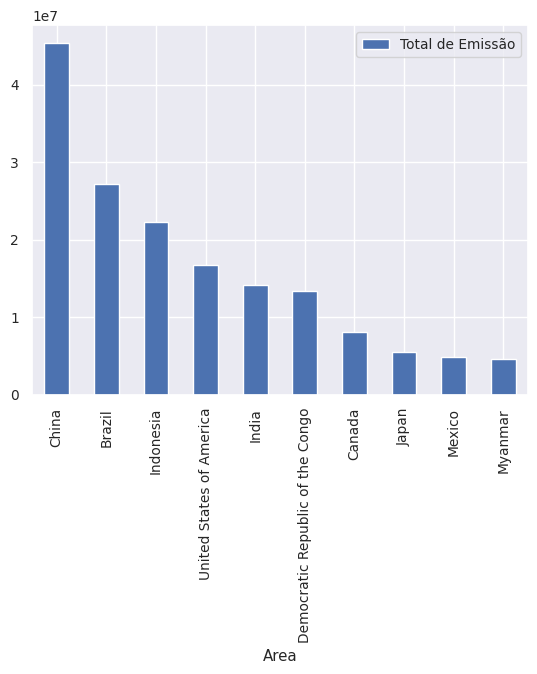



 Os 10 maiores produtores de alimentos no periodo 1994 - 2019
['China', 'Brazil', 'Indonesia', 'United States of America', 'India', 'Democratic Republic of the Congo', 'Canada', 'Japan', 'Mexico', 'Myanmar']


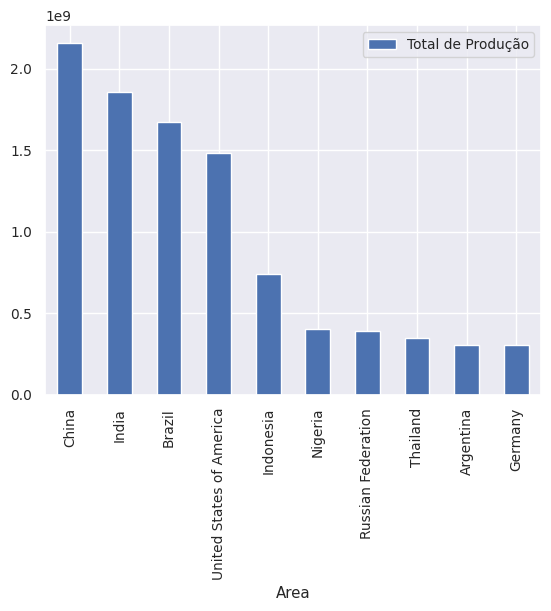

In [102]:
# Análise Inicial das Emissões
# (1) Os 10 maiores paises emissores de CO2 no periodo, e o total das suas emissões no periodo de análise

print('\n\n', 'Análises Iniciais')
print('\n\n', 'Os 10 maiores paises emissores de CO2 no periodo 1994 - 2019')

df_maiores_emissores = df.groupby('Area')['total_emission'].sum().reset_index().sort_values(by='total_emission', ascending=False).head(10)
maiores_emissores =list(df_maiores_emissores['Area'].unique())
print(maiores_emissores)
df_maiores_emissores.plot.bar(x='Area', y='total_emission',label='Total de Emissão');

plt.show()

# (2) Os 10 maiores paises produtores de Alimentos, e o total da produção de alimentos no periodo de análise

print('\n\n', 'Os 10 maiores produtores de alimentos no periodo 1994 - 2019')

df_maiores_produtores = df.groupby('Area')['Total'].sum().reset_index().sort_values(by='Total', ascending=False).head(10)
maiores_produtores =list(df_maiores_emissores['Area'].unique())
print(maiores_produtores)
df_maiores_produtores.plot.bar(x='Area', y='Total',label='Total de Produção');

plt.show()

# **Análise**

As análise focará nos 5 maiores produtores de alimento (China, India, Brazil, Indonesia e Estados Unidos) bem como  Congo (apesar da mesma  não ser uma grande produtora de alimento).

O objetivo é identificar padrões ou características das suas fontes de emissões, assim



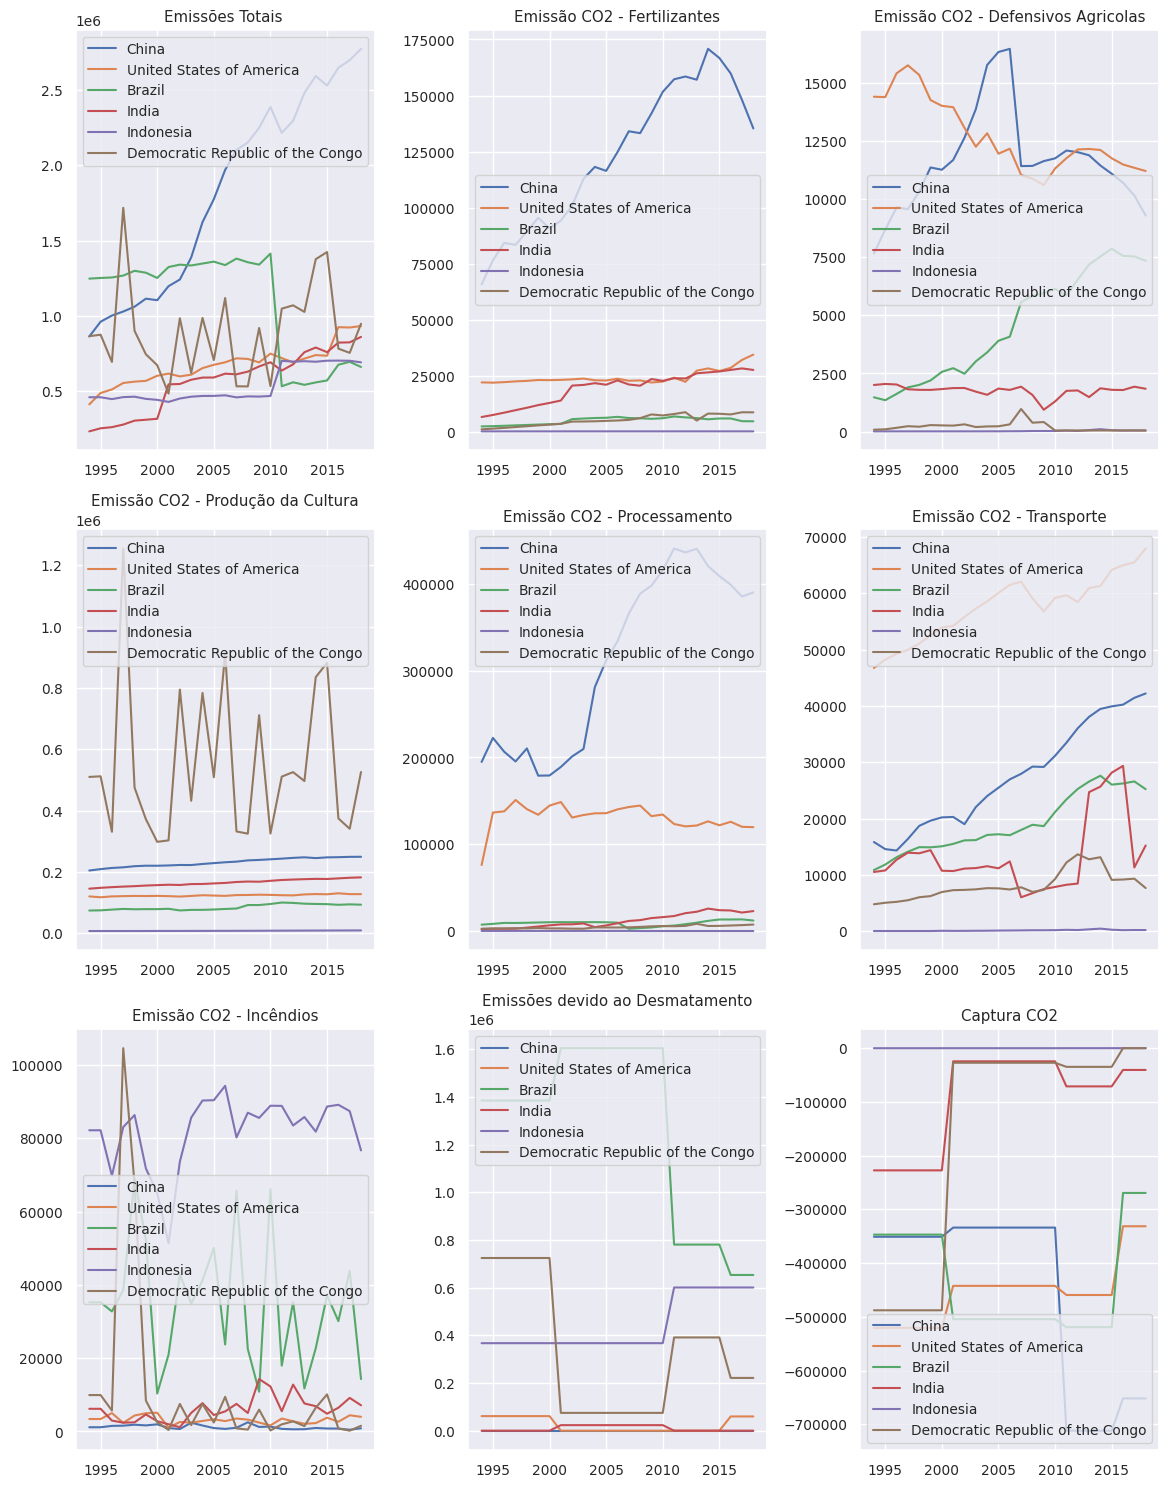

In [103]:
maiores_produtores = ['China', 'United States of America','Brazil', 'India','Democratic Republic of the Congo','Indonesia']


# Uma visão geral de cada um dos 5 maiores produtores de alimentos com relação
# (1) total de emissão de Co2 por ano no periodo
# (2) Discriminação das emissões nas diferentes visões estabelecidas relacionadas com a Cadeia de Produção
#     (i)     Produção de Fertilizantes
#     (ii)    Produção de Defensivos Agricolas
#     (iii)   Produção dos Alimentos
#     (iv)    Processamento dos Alimentos
#     (v)     Distribuição dos Alimentos
# (3) Emissões de CO2 decorrentes de incêndios nos Biomas do Pais
# (4) Emissões de CO2 decorrentes do Processamento de Desmatamento
# (5) Finalmente, a absorção de CO2 decorrente da cobertura florestal
# Obs : Definida uma paleta de cores com o objetivo de identificar os paises, e no caso dos incêndios uma identificação do BIOMA

fig, ax = plt.subplots(3,3, figsize = (12, 15))
cores_incendios={'Savanna fires':'r', 'Forest fires':'b','Fires in humid tropical forests':'gray'}
cores_paises_produtores = { 'China': '#E69F00',  # Orange
                           'United States of America': '#56B4E9',  # Sky Blue
                           'Brazil': '#009E73',  # Bluish Green
                           'India': '#F0E442',  # Yellow
                           'Indonesia': '#0072B2',  # Blue
                           'Democratic Republic of the Congo': '#D55E00'  # Vermilion
}

for pais in maiores_produtores:
    formatar_plotagem (df,'Year',pais,'Emissões Totais ', cores_paises_produtores,0,0,'total_emission')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Fertilizantes', cores_paises_produtores,0,1,'Fertilizers Manufacturing')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Defensivos Agricolas', cores_paises_produtores,0,2,'Pesticides Manufacturing')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Produção da Cultura', cores_paises_produtores,1,0,'soma_emissao_co2_cultivo')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Processamento', cores_paises_produtores,1,1,'soma_emissao_co2_cadeia_processamento')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Transporte', cores_paises_produtores,1,2,'Food Transport')
    formatar_plotagem (df,'Year',pais,'Emissão CO2 - Incêndios', cores_paises_produtores,2,0,'soma_emissao_co2_incendio')
    formatar_plotagem (df,'Year',pais,'Emissões devido ao Desmatamento', cores_paises_produtores,2,1,'Net Forest conversion')
    formatar_plotagem (df,'Year',pais,'Captura CO2', cores_paises_produtores,2,2,'Forestland')

plt.tight_layout()
plt.show()



O primeiro conjunto de gráficos permitem algumas constatações

(1) China apresenta a maior nível de emissão de CO2, seguido - nos últimos tempos - pela Indonésia, Estados Unidos, India e Brasil

(2) Na produção de Fertilizantes, de  Defensivos Agricolas, e durante o  Processamento dos Alimentos  China e Estados Unidos dominam as emissões nestas etapas da cadeia de alimentos, de certa forma é uma decorrência do nível de industrialização  destes países

(3) Na etapa de produção dos alimentos, o Brasil tem a menor taxa de emissão de CO2 (Indonésia se destaca como maior emissor).

(4) No que diz respeito as emissões decorrentes de incêndios nos Biomas, ou decorrente do desmatamento o Brasil apresenta, em especial neste último, um forte componente emissor.

## Análise de Covariance entre

(1) As fontes de emissão de CO2 durante o cultivo de uma cultura, e a emissão total

(2) Incendios Florestas ou no Biomas e a emissão total

(3) Desmatamento e a emissão de CO2


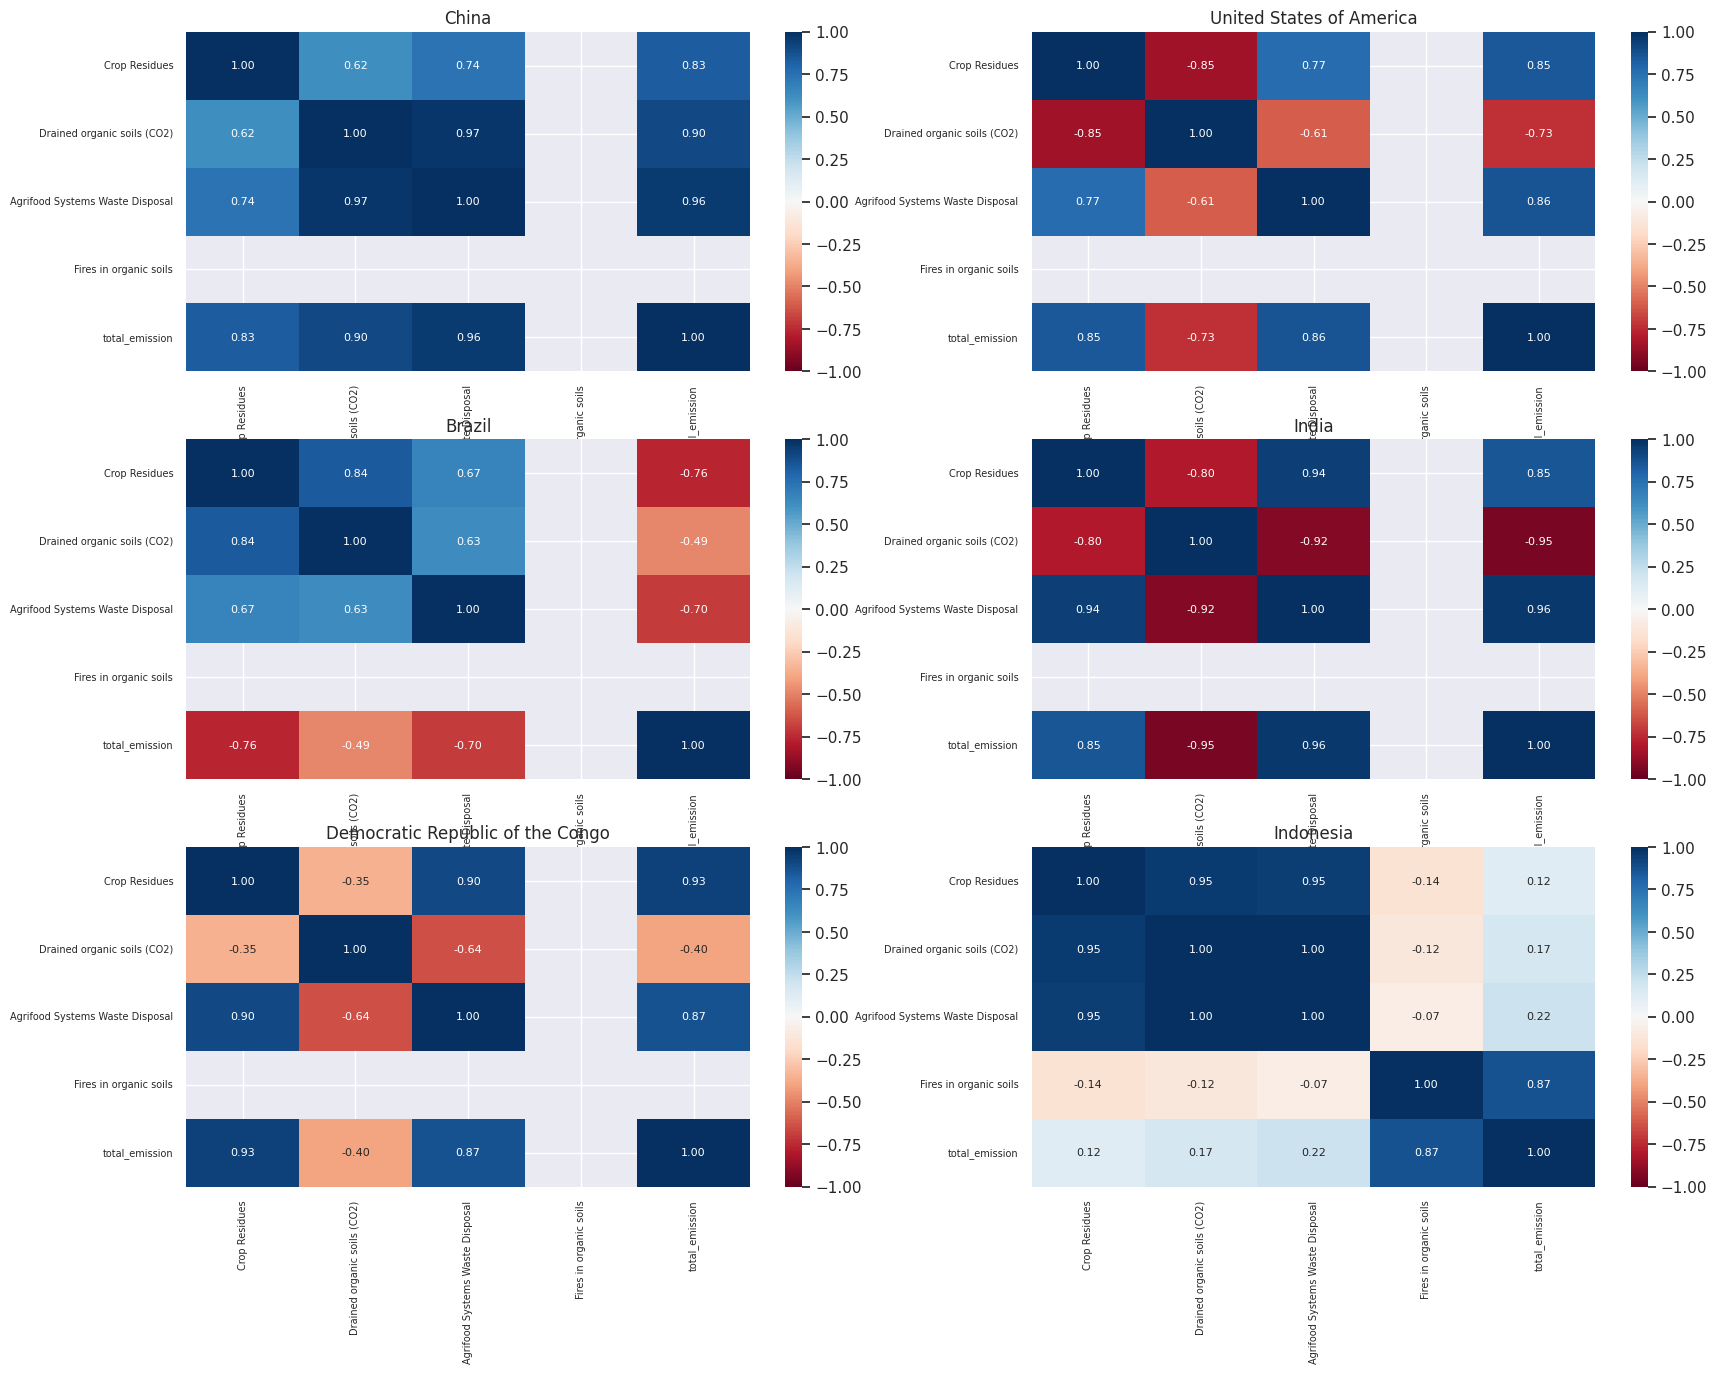

()

In [ ]:

grafico_heatmap(df,fontes_emissao_co2_cultivo,maiores_produtores)



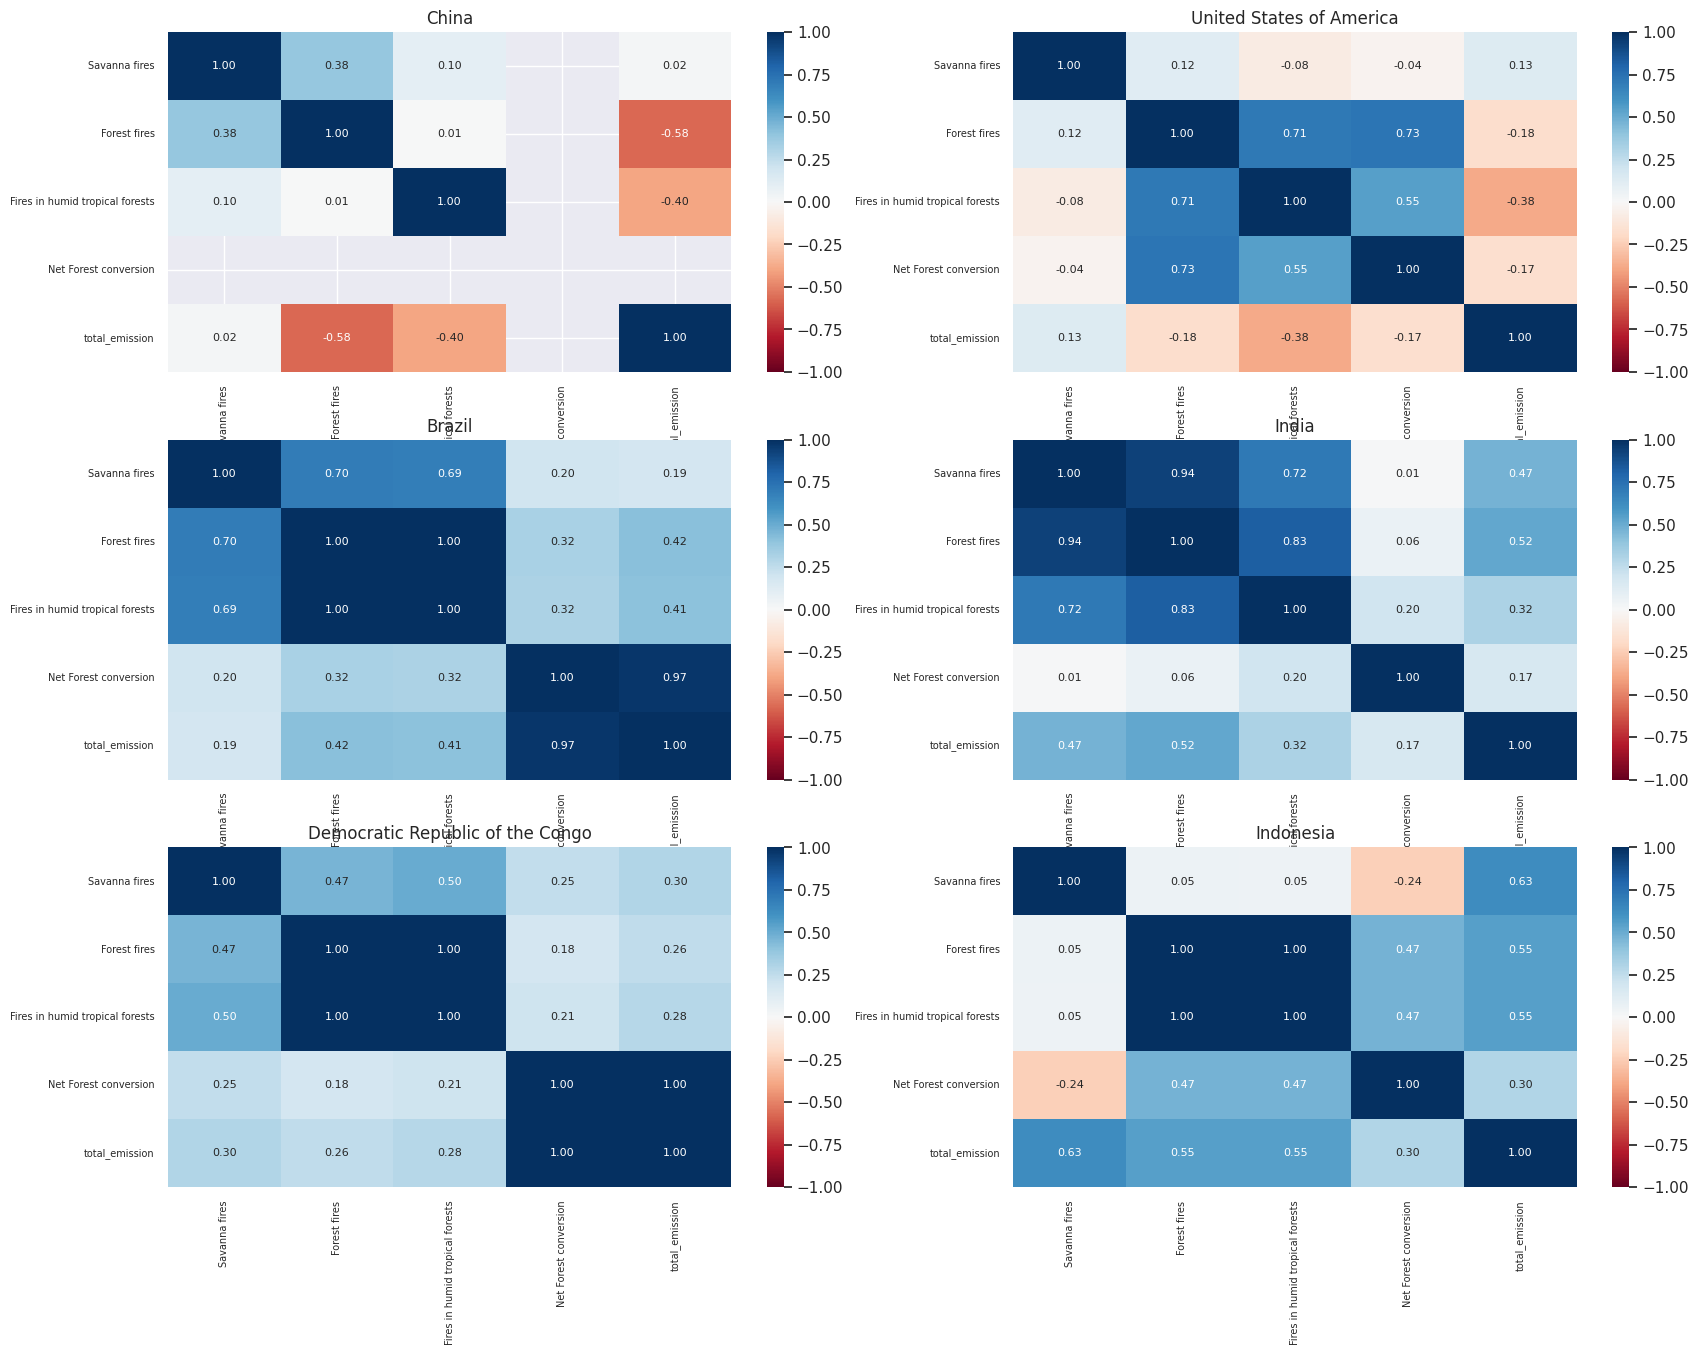

()

In [ ]:
grafico_heatmap(df,incendios + ['Net Forest conversion'],maiores_produtores)

Análise de Covariance entre os tipos de alimentos produzidos e a emissão de CO2

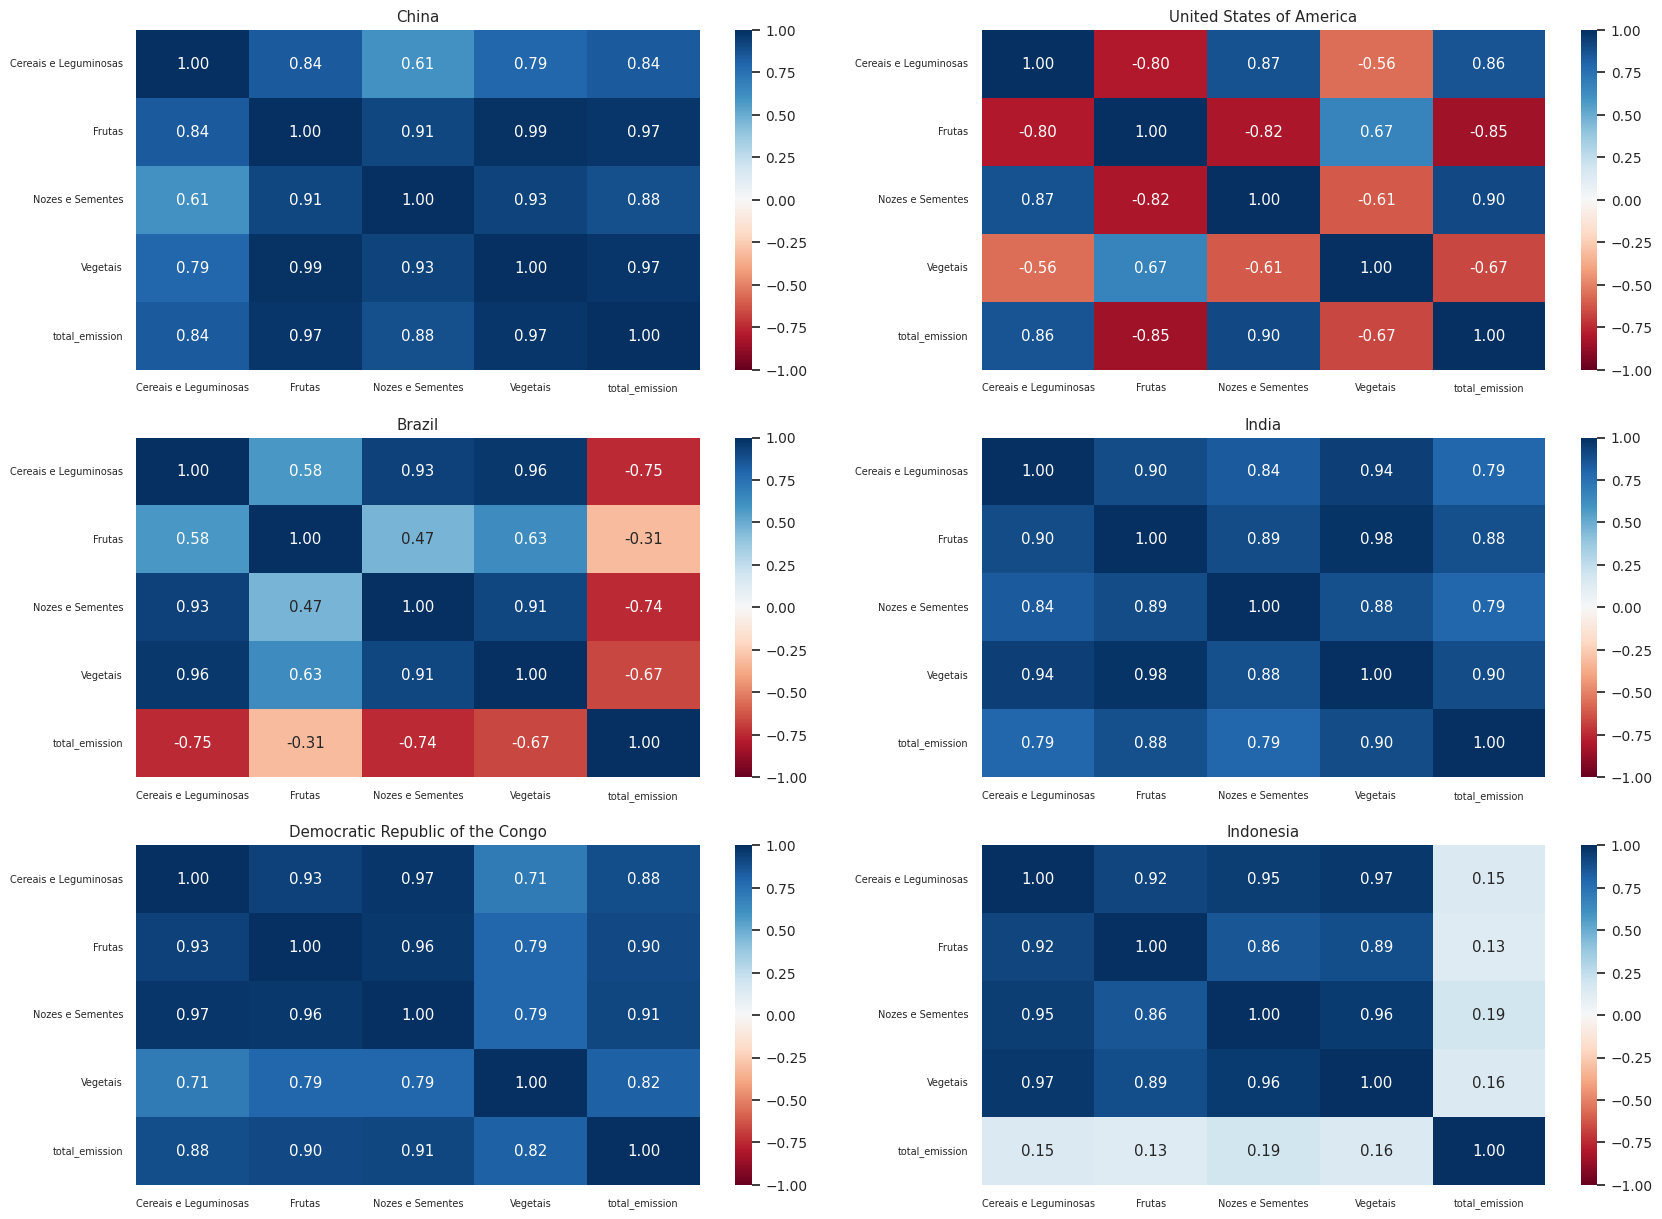

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (20, 15))
sns.set(font_scale=0.9)
i=j=0
for pais in maiores_produtores:
  sns.heatmap(df[df.Area == pais].loc[:,['Cereais e Leguminosas', 'Frutas', 'Nozes e Sementes', 'Vegetais','total_emission']].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1,fmt="1.2f",ax=ax[i,j])
  ax[i,j].set_title(pais)
  ax[i,j].tick_params(axis='both', which='major', labelsize=7)
  j+=1
  if j == 2:
    i+=1
    j=0
plt.show()

Identificar cluster de paises

Identificar cluster de paises

(1) selecionar dados


<ipython-input-108-d91311b15300>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['Net Forest conversion']=df_2018['Net Forest conversion'].fillna(0)


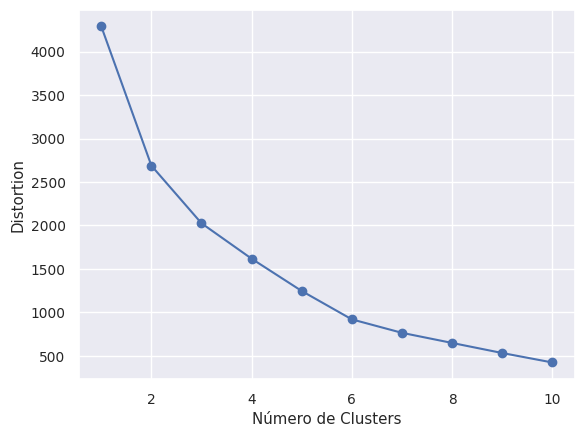

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [108]:
df_2018=df[df['Year']==2018]
df_2018['Net Forest conversion']=df_2018['Net Forest conversion'].fillna(0)

df_2018=df_2018.dropna(axis=1)

df_clus=df_2018.drop(['Area','Year','Urban population', 'Total Population - Male','Total Population - Female','soma_emissao_co2_cultivo', 'soma_emissao_co2_incendio',
                      'soma_emissao_co2_cadeia_processamento','Total'],axis=1)

df_sc = StandardScaler()

df_sc = sc.fit_transform(df_clus)

df_sc = pd.DataFrame(df_sc, columns=df_clus.columns)

distortions = []

for i  in range(1,11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(df_sc)
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Distortion')
plt.show()


# selecionado 10 clusters

model = KMeans(n_clusters=10, random_state=1)
model.fit(df_sc)
cluster = model.labels_
df_clus['Area']=df_2018['Area']
df_clus['Cluster']=cluster


In [120]:
df_clus.groupby('Cluster')[['Frutas','total_emission']].mean()


,Frutas,total_emission
Cluster,,
0,2.007533e+05,2.030269e+04
1,1.754923e+07,2.773948e+06
2,3.634684e+06,9.466571e+05
3,1.081644e+07,8.591472e+05
4,4.316007e+06,6.592756e+05
5,1.065200e+06,1.426909e+05
6,6.433887e+05,2.111945e+05
7,2.800554e+05,1.574680e+05
8,1.365224e+05,2.161852e+04


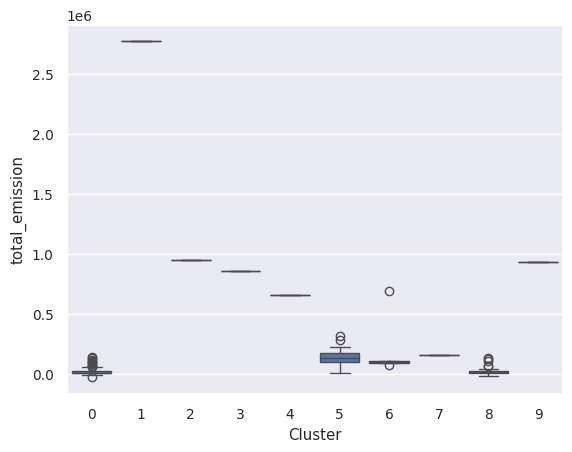

In [109]:
sns.boxplot(x='Cluster',y='total_emission',data=df_clus)
df_clus.groupby('Cluster')

NameError: name 'clus_col2' is not defined

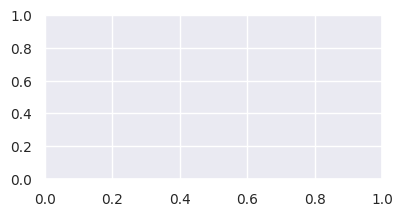

In [ ]:
fig = plt.figure(figsize=(20,20))

for i in range(4):
    plt.subplot(8,4,i+1)
    sns.scatterplot(df_clus,x=df_clus[clus_col2[i]],y=df_clus['total_emission'],hue=df_clus['Cluster'],palette="Pastel1")
    plt.title(clus_col2[i],fontsize=5)

plt.tight_layout()
plt.show()